In [1]:
import methods as me

import numpy as np
from matplotlib import pyplot as plt, gridspec, lines
import itertools as it
from scipy.optimize import minimize, curve_fit
from scipy.signal import find_peaks
from scipy.misc import electrocardiogram
from scipy import fftpack

import time

#  dir of this repo
dir_home = '/home/rmentel/interpolating-orbits/Github/'
dir_params = dir_home + 'params/'
dir_data = dir_home + 'data/'

In [2]:
# Define needed constants and labels

# AU to m
AU_to_M = 1.496*10**11
# AU/y to m/s
AUpY_to_MpS = 4743.183
# solar mass to kg
SM_to_kg = 1.988435*10**30
# gravitational constant G[m^3/kg*s^2]
G = 6.67428*10**-11
# gravitational parameter mu
mu = 1.327137415503024*10**20

n_b = 9 # number of bodies
batchsize = 11

# Labels for axes
name_label = ['Sun', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']
name_short = ['S', 'V', 'E', 'M', 'J', 'S', 'U', 'N', 'P']
oe_label = ['Semimajor Axis [AU]', 'Eccentricity', 'Inclination [Deg]', 'A. of periapsis [Rad]', 'L. of ascending node [Rad]']
planetperiods = np.array([0.6152, 1, 1.8808, 11.862, 29.447, 84.012, 164.789, 249.589])
# ratios = [1/6, 5/6, 1/5, 2/5, 3/5, 4/5, 3/4, 1/4, 2/3, 1/3, 1/2, 1, 2/1, 3/1, 3/2, 4/3, 4/1, 5/1, 5/2, 5/3, 5/4, 6/5, 6/1]
# ratios = [1/5, 2/5, 3/5, 4/5, 3/4, 1/4, 2/3, 1/3, 1/2, 1, 2/1, 3/1, 3/2, 4/3, 4/1, 5/1, 5/2, 5/3, 5/4]
ratios = [3/4, 1/4, 2/3, 1/3, 1/2, 1, 2/1, 3/1, 3/2, 4/3, 4/1]

cols = ['k', 'r', 'g', 'b', 'c', 'y', 'm', 'k']

In [3]:
# Print synodic periods for nice overview
me.SynPeriod(4,5)
n = 8
for i in range(8):
    print (name_label[i+1], [round(me.SynPeriod(i+1, j+1),2) for j in range(n)])

Venus [0.62, 1.6, 0.91, 0.65, 0.63, 0.62, 0.62, 0.62]
Earth [1.6, 1.0, 2.14, 1.09, 1.04, 1.01, 1.01, 1.0]
Mars [0.91, 2.14, 1.88, 2.24, 2.01, 1.92, 1.9, 1.9]
Jupiter [0.65, 1.09, 2.24, 11.86, 19.86, 13.81, 12.78, 12.45]
Saturn [0.63, 1.04, 2.01, 19.86, 29.45, 45.34, 35.85, 33.39]
Uranus [0.62, 1.01, 1.92, 13.81, 45.34, 84.01, 171.39, 126.64]
Neptune [0.62, 1.01, 1.9, 12.78, 35.85, 171.39, 164.79, 485.02]
Pluto [0.62, 1.0, 1.9, 12.45, 33.39, 126.64, 485.02, 249.59]


In [4]:
def PlotSynodics(Ax, B, LW):
    for j in range(n_b-1):
        i = j+1
        F = 1/me.SynPeriod(B, i)
        Ax.axvline(x=F, c=cols[i-1], lw=LW, label="Syn. p. of " + str(name_label[B]) + " with " + str(name_label[i]) + str(": ") + str(round(me.SynPeriod(B,i),1)))
        print (name_label[i], round(1/F,1))

def PlotSynodic(Ax, B, I, C, LW):
    F = 1/me.SynPeriod(B, I)
    Ax.axvline(x=F, c=C, lw=LW, ls='--', label="Syn. p. of " + str(name_label[B]) + " with " + str(name_label[I]) + str(": ") + str(round(me.SynPeriod(B,I),1)))
    Ax.text(F, 2*ymin, str(name_short[I]), fontsize=16, c='r')
    print ("Synodic period with", name_label[I], round(1/F,1))

In [5]:
def PlotResonances(Ax, B, Res, Ymin, C):
    Lw = 1
    Period = planetperiods[B-1]
    for R in Res:
        F = R/Period
        Ax.axvline(F, lw=Lw, c=C, label=str(round(R,2)) + '-line of ' + str(name_label[B]) )
        Ax.text(F, Ymin, str(round(R,2)), fontsize=16)
        print (str(round(R,2)) + '-line of ' + str(name_label[B]) + ' at year ' + str(round(1/F,1)))

def PlotTestRatios(Ax, B, Ratios, Ymin, C):
    Lw = 2
    Ls = ':'
    Period = planetperiods[B-1]
    R = Ratios[0]
    Freq = R/Period
    Ax.axvline(x=Freq, lw=Lw, ls=Ls, c=C, label="Possible resonance freq's with " + name_label[B])
    Ax.text(Freq, Ymin, str(round(R,2)), fontsize=16)
    for R in Ratios[1:]:
        Freq = R/Period
        Ax.axvline(x=Freq, lw=Lw, ls=Ls, c=C)
        Ax.text(Freq, Ymin, str(round(R,2)), fontsize=16)

def PlotPeriods(Ax, Ymin, C):
    Lw=1
    for I in range(len(planetperiods)):
        P = planetperiods[I]
        F = 1/P
        Ax.axvline(F, lw=Lw, c=C)
        Ax.text(F, 2*Ymin, name_short[1+I], fontsize=16)

In [6]:
def PlotResonantSynodics(Ax, B, J, Ratios, C):
    Lw = 1
    Ls = '--'
    PSyn = me.SynPeriod(B, J)
    R = Ratios[0]
    Freq = R/PSyn
    Ax.axvline(x=Freq, lw=Lw, ls=Ls, c=C, label="Resonant Synodics of " + name_label[B] + " with " + name_label[J])
    Ax.text(Freq*1.01, ymin*2.5, name_short[J], fontsize=16, color='r', zorder=10)
    Ax.text(Freq*1.01, ymin*1.5, str(round(R,2)), fontsize=16, color='r', zorder=10)

    for R in Ratios[1:]:
        Freq = R/PSyn
        Ax.axvline(x=Freq, lw=Lw, ls=Ls, c=C)
        Ax.text(Freq*1.01, ymin*2.5, name_short[J], fontsize=16, color='r', zorder=10)
        Ax.text(Freq*1.01, ymin*1.5, str(round(R,2)), fontsize=16, color='r', zorder=10)

In [45]:
# Read in NEW Brutus data

file = open(dir_data + 'outputs/brutus_venus_to_pluto_62800y_182d_e14_lw128.txt', 'r')
body_n = file.readlines()[:]
steps = 125500
# steps = 1000

# Define arrays for cartesians and timeline
time_n = np.zeros((int(steps), 1))
cart_n = np.zeros((int(steps), n_b, 7))
kepl_n = np.zeros((int(steps), n_b, 7))

# Write array of cartesian parameters: Solar mass, AU, AU/Y
for i in range(int(steps)): # for all time steps ...
    batch = body_n[(batchsize*i):(batchsize*(i+1))]
    time_n[i, 0] = float(((batch[0]).split()[0]))
    for j, line in enumerate(batch[1:-1]): # for all bodies...
        words = line.split()
        cart_n[i, j, :] = [float(x) for x in words]
        cart_n[i, j, 4:8] = cart_n[i, j, 4:8]

for i, step in enumerate(cart_n[:steps]):
    # Calculate COM:
    R_COM = np.zeros((1,3))
    V_COM = np.zeros((1,3))
    M = 0
    for j in range(8):
        m = SM_to_kg*step[j, 0]
        M = M + m
        R = AU_to_M*step[j, 1:4]
        V = AUpY_to_MpS*step[j, 4:7]
        R_COM = R_COM + m*R
        V_COM = V_COM + m*V
    r_COM = R_COM/M
    v_COM = V_COM/M
#     SINGLE BODY
    j = 4
#     for j in range(9):
    m = SM_to_kg*step[j, 0]
    R = AU_to_M*step[j, 1:4]
    V = AUpY_to_MpS*step[j, 4:8]
    r = (R - r_COM)[0]
    v = (V - v_COM)[0]
# a, e, i, om, Om, M, E
#     SINGLE ELEMENT
    kepl_n[i, j, 0] = me.CartesianToKepler(m, r, v)[0]/AU_to_M
    k = 0
#     for k in range(6):
    kepl_n[i, j, k+1] = me.CartesianToKepler(m, r, v)[k+2]

# kepl_new62k = kepl_n
# time_new62k = time_n

In [46]:
print (kepl_n[0,j,:])

[5.19916704 0.04893733 0.         0.         0.         0.
 0.        ]


1.0
1-line of Earth at year 1.0
1-line of Jupiter at year 11.9
2-line of Jupiter at year 5.9
3-line of Jupiter at year 4.0
4-line of Jupiter at year 3.0
1-line of Saturn at year 29.4
2-line of Saturn at year 14.7
3-line of Saturn at year 9.8
4-line of Saturn at year 7.4


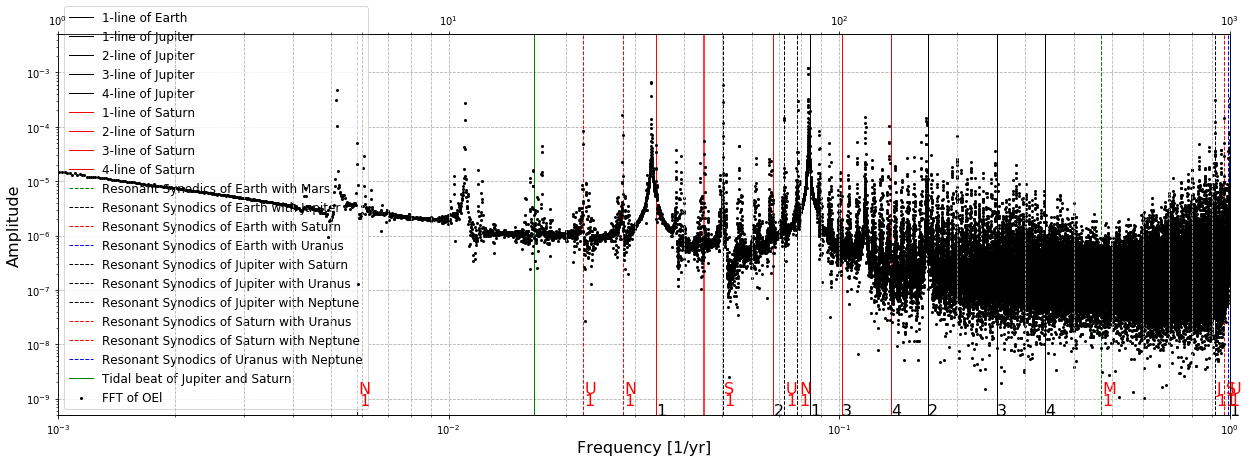

1116.1 0.0 -2.0098729454096027
193.5 0.01 -2.71866083332634
90.8 0.01 -3.1829391940450185
35.9 0.03 -3.4858450267434136
30.3 0.03 -3.6195582141790688
19.8 0.05 -3.720771333081297
13.8 0.07 -3.8043268698141866
12.8 0.08 -3.8739626241242284
12.0 0.08 -3.9340381978975176
12.0 0.08 -3.984723691401392
11.9 0.08 -4.028877901367722
8.6 0.12 -4.077345925683125
8.6 0.12 -4.113080335320635
8.5 0.12 -4.149027379730862
7.5 0.13 -4.180621591544166
6.0 0.17 -4.211733110182596
6.0 0.17 -4.239132950940255
1.1 0.92 -4.264224459163169
1.0 0.97 -4.294271213411702
1.0 1.0 -4.313302690526227


In [44]:
# Earth

b = 2
c = 1
# me.Names(b,c)
print (planetperiods[b-1])

n_1 = 0
n_2 = 125000

new = np.zeros((len(kepl_n), 2))
new[:,0] = time_n[:, 0]
new[:,1] = kepl_n[:, b, c]

x = new[n_1:n_2,0]
s = new[n_1:n_2,1]


t = 0.5
fy = fftpack.fft(s)
N = len(s)
result = np.abs(fy)[:N // 2] * 1 / N
x_f = np.linspace(0, 1/t, N)
xf = x_f[:N // 2]

min_h = 1e-4
peaks, _ = find_peaks(result, height = min_h, prominence=1e-7)

freqs = xf[peaks]
periods = 1/xf[peaks]

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ax.scatter(xf, result, s=4, c='k', zorder=10, label='FFT of OEl')
# ax.plot(xf[peaks], result[peaks], lw=0, ms=30, c='r', marker='o', mfc='w', label='Highest peaks above blue vertical')
# plt.axhline(y=min_h, c='b', lw=.7)

ymin, ymax = 5e-10, 5e-3
xmin, xmax = 1e-3, 1
x2min, x2max = 1/xmax, 1/xmin


# PlotSynodics(ax, b, 1)

# SMA
PlotResonances(ax, 2, [1], ymin, 'k')
PlotResonances(ax, 4, [1, 2, 3, 4], ymin, 'k')
PlotResonances(ax, 5, [1, 2, 3, 4], ymin, 'r')
PlotResonantSynodics(ax, b, 3, [1], 'g')
PlotResonantSynodics(ax, b, 4, [1], 'k')
PlotResonantSynodics(ax, b, 5, [1], 'r')
PlotResonantSynodics(ax, b, 6, [1], 'b')
PlotResonantSynodics(ax, 4, 5, [1], 'k')
PlotResonantSynodics(ax, 4, 6, [1], 'k')
PlotResonantSynodics(ax, 4, 7, [1], 'k')
PlotResonantSynodics(ax, 5, 6, [1], 'r')
PlotResonantSynodics(ax, 5, 7, [1], 'r')
PlotResonantSynodics(ax, 6, 7, [1], 'b')


# ECC
# PlotResonances(ax, 4, [1, 2, 3, 4], ymin, 'k')
# PlotResonances(ax, 5, [1, 2, 3, 4], ymin, 'r')
# PlotResonantSynodics(ax, b, 4, [1], 'k')
# PlotResonantSynodics(ax, b, 5, [1], 'r')
# PlotResonantSynodics(ax, b, 6, [1], 'b')
# PlotResonantSynodics(ax, 4, 5, [1], 'k')
# PlotResonantSynodics(ax, 4, 6, [1], 'k')
# PlotResonantSynodics(ax, 4, 7, [1], 'k')
# PlotResonantSynodics(ax, 5, 6, [1], 'r')
# PlotResonantSynodics(ax, 5, 7, [1], 'r')
# PlotResonantSynodics(ax, 6, 7, [1], 'b')


ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xlim(x2min, x2max)
ax2.set_xscale('log')

ax.grid(which='major', axis='y', ls='--')
ax2.grid(which='both', ls='--')

ax.set_xlabel('Frequency [1/yr]', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
# ax.set_tick_params(which='minor', labelsize=16, axis='x')
# plt.title('FFT of ' + oe_label[c] + ' of ' + name_label[b], fontsize=20)

ax.axvline(1/60.3, c='g', lw=1, label='Tidal beat of Jupiter and Saturn')
ax.axvline(1/22.14, c='r')

ax.legend(loc=3, fontsize=12)
plt.show()
plt.close()

# n_peaks = 20
for i in range (len(peaks)):
    print (round(periods[i], 1), round(freqs[i], 2), np.log10(result[i]))

1.8808
1-line of Jupiter at year 11.9
1-line of Saturn at year 29.4
1-line of Uranus at year 84.0
1-line of Neptune at year 164.8


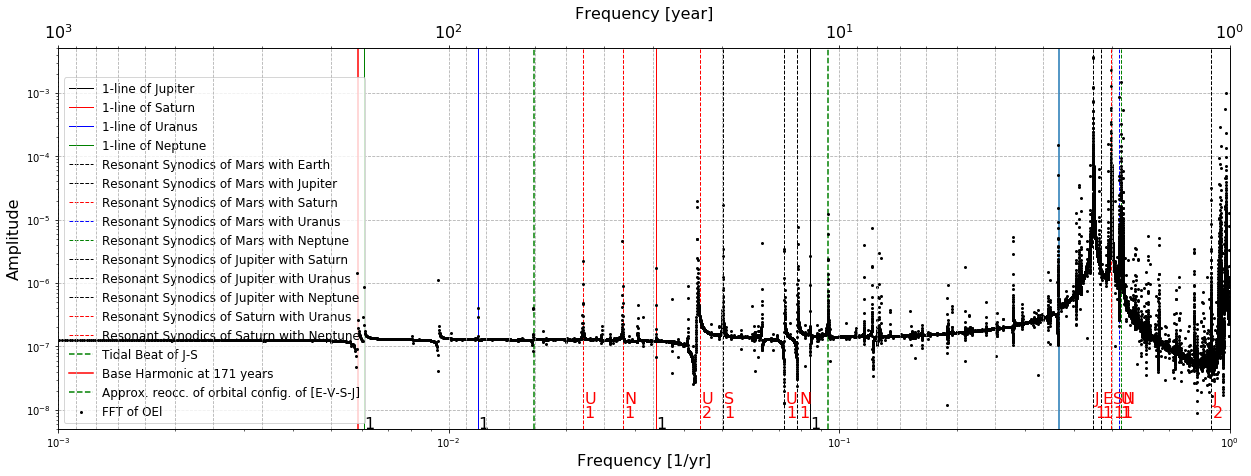

23.1 0.04 0.1833854433699318
19.8 0.05 -6.873368009562997
10.7 0.09 -6.894735233536605
2.8 0.36 -6.898983564812401
2.5 0.4 -6.887367070953738
2.4 0.41 -6.889639080591761
2.4 0.42 -6.889117682333505
2.3 0.44 -6.888581556843063
2.2 0.45 -6.888081706598643
2.2 0.45 -6.887689360286242
2.2 0.45 -6.887170779209676
2.2 0.46 -6.8865368083957375
2.0 0.49 -6.8855945463430235
2.0 0.5 -6.883242463497367
2.0 0.5 -6.8718957555571105
2.0 0.51 -6.896358389873476
1.9 0.52 -6.890609195389637
1.9 0.53 -6.889135378604034
1.9 0.53 -6.88825878577653
1.1 0.9 -6.887998320533238
1.1 0.94 -6.886942669949098
1.1 0.94 -6.886643852320132
1.1 0.95 -6.886298137809642
1.0 0.97 -6.885572972907026
1.0 0.98 -6.8853036196016975
1.0 1.0 -6.885113094016478


In [48]:
# Mars

# fig = plt.figure(figsize=(21,7))
# ax = fig.add_subplot(111)

# ax.scatter

# ax
# PlotSynodics(ax, b,'r')

b = 3
c = 0
# me.Names(b,c)
print (planetperiods[b-1])

n_1 = 0
n_2 = 125000

new = np.zeros((len(kepl_n), 2))
new[:,0] = time_n[:, 0]
new[:,1] = kepl_n[:, b, c]

x = new[n_1:n_2,0]
s = new[n_1:n_2,1]

ymin, ymax = 5e-9, 5e-3
xmin, xmax = 1e-3, 1e-0
x2min, x2max = 1/xmin, 1/xmax

t = 0.5
fy = fftpack.fft(s)
N = len(s)
result = np.abs(fy)[:N // 2] * 1 / N
x_f = np.linspace(0, 1/t, N)
xf = x_f[:N // 2]

min_h = 1e-5
peaks, _ = find_peaks(result, height = min_h, prominence=1e-5)

freqs = xf[peaks]
periods = 1/xf[peaks]

############

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ax.scatter(xf, result, s=4, c='k', zorder=10, label='FFT of OEl')
# ax.plot(xf[peaks], result[peaks], lw=0, ms=30, c='r', marker='o', mfc='w', label='Highest peaks above blue vertical')
# plt.axhline(y=min_h, c='b', lw=.7)



# PlotSynodics(ax, b, 1)
# i = 
# me.PlotTestRatios(ax, 4, [1,2,3], ymin, 'k')
# PlotResonantSynodics(ax, b, 6, [1], 'g')

# PlotResonantSynodics(ax, b, 6, [1, 5/2, 3, 4], ymin, 'g')

# ECC
# PlotResonances(ax, 3, [1], ymin, 'g')
PlotResonances(ax, 4, [1], ymin, 'k')
PlotResonances(ax, 5, [1], ymin, 'r')
PlotResonances(ax, 6, [1], ymin, 'b')
PlotResonances(ax, 7, [1], ymin, 'g')
PlotResonantSynodics(Ax=ax, B=b, C='k', J=2,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=b, C='k', J=4,Ratios=[1,2])
PlotResonantSynodics(Ax=ax, B=b, C='r', J=5,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=b, C='b', J=6,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=b, C='g', J=7,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=4, C='k', J=5,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=4, C='k', J=6,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=4, C='k', J=7,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=5, C='r', J=6,Ratios=[1,2])
PlotResonantSynodics(Ax=ax, B=5, C='r', J=7,Ratios=[1])
# SMA
# PlotResonances(ax, 4, [1], ymin, 'k')
# PlotResonances(ax, 5, [1], ymin, 'r')
# PlotResonances(ax, 6, [1], ymin, 'b')
# PlotResonances(ax, 7, [1], ymin, 'g')
# PlotResonantSynodics(Ax=ax, B=b, C='k', J=2,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=b, C='k', J=4,Ratios=[1,2])
# PlotResonantSynodics(Ax=ax, B=b, C='r', J=5,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=b, C='b', J=6,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=b, C='g', J=7,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=4, C='k', J=5,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=4, C='k', J=6,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=4, C='k', J=7,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=5, C='r', J=6,Ratios=[1,2])
# PlotResonantSynodics(Ax=ax, B=5, C='r', J=7,Ratios=[1])


ax.set_xlabel('Frequency [1/yr]', fontsize=16)
ax2.set_xlabel('Frequency [year]', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
ax.tick_params(which='minor', labelsize=16, axis='x')
ax2.tick_params(which='both', labelsize=16, axis='x')
# ax2.set_xticks([1,2,3,4,5,10,20,30,40,50,100])
# ax2.set_xticklabels(('1','2','3','4','5','10','20','30','40','50','100'))

ax.grid(which='major', axis='y', ls='--')
ax2.grid(which='both', ls='--')

# plt.title('FFT of ' + oe_label[c] + ' of ' + name_label[b], fontsize=20)

ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax2.set_xlim(x2min, x2max)

ax.set_xscale('log')
ax2.set_xscale('log')
ax.set_yscale('log')

ax.axvline(1/60.5, c='g', ls='--', label='Tidal Beat of J-S')
ax.axvline(1/171, c='r', label='Base Harmonic at 171 years')
ax.axvline(1/10.65, c='g', ls='--', label='Approx. reocc. of orbital config. of [E-V-S-J]')
ax.axvline(1/2.74)

ax.axvline(1/7.4, c='g', lw=1, label='Synodic Period with JS-Synodic (7.4y)')
# ax.axvline(1/6., c='b')
# ax.axvline(1/2.74, c='b')

ax.legend(loc=3, fontsize=12)
plt.show()
plt.close()

for i in range (len(peaks)):
    print (round(periods[i], 1), round(freqs[i], 2), np.log10(result[i]))

11.862
1-line of Jupiter at year 11.9
1-line of Saturn at year 29.4
2-line of Saturn at year 14.7


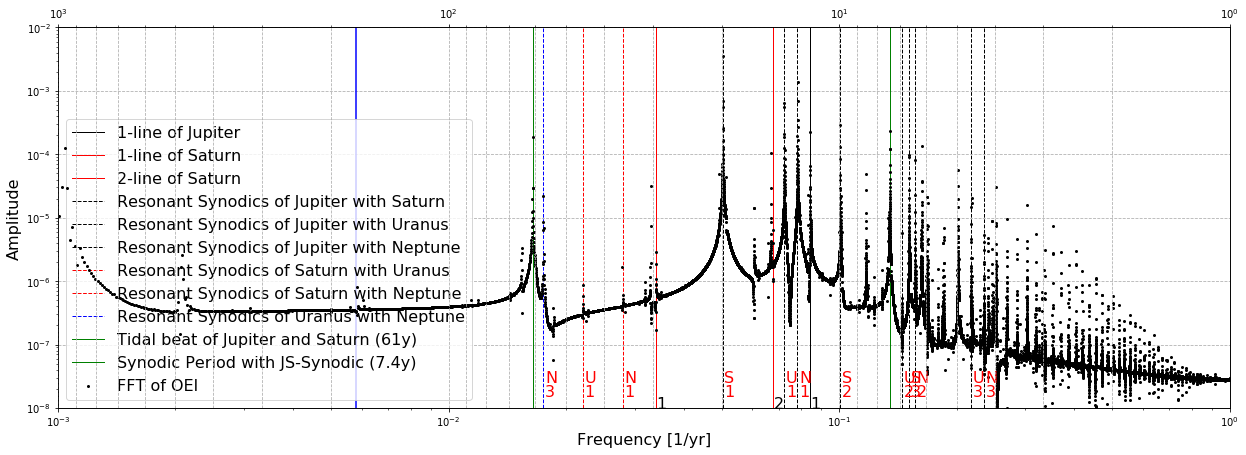

961.5 0.0 0.7154496451615634
60.9 0.02 -5.0523863728052385
19.8 0.05 -5.572711076877965
15.0 0.07 -6.2507515201179755
13.8 0.07 -6.138853620367257
12.8 0.08 -6.2696677076630944
11.9 0.08 -6.088087713580606
9.9 0.1 -6.144205028873293
7.4 0.13 -6.143439619222473
6.6 0.15 -6.141239245086691
6.4 0.16 -6.142876211721614
6.1 0.16 -6.1425359129886425


In [47]:
# Jupiter ECC

# fig = plt.figure(figsize=(21,7))
# ax = fig.add_subplot(111)

# ax.scatter

# ax
# PlotSynodics(ax, b,'r')

b = 4
c = 0
# me.Names(b,c)
print (planetperiods[b-1])

n_1 = 0
n_2 = 125000

new = np.zeros((len(kepl_n), 2))
new[:,0] = time_n[:, 0]
new[:,1] = kepl_n[:, b, c]

x = new[n_1:n_2,0]
s = new[n_1:n_2,1]


t = 0.5
fy = fftpack.fft(s)
N = len(s)
result = np.abs(fy)[:N // 2] * 1 / N
x_f = np.linspace(0, 1/t, N)
xf = x_f[:N // 2]

min_h = 7e-5
peaks, _ = find_peaks(result, height = min_h, prominence=1e-5)

freqs = xf[peaks]
periods = 1/xf[peaks]

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(111)
ax2 = ax.twiny()

ax.scatter(xf, result, s=4, c='k', zorder=10, label='FFT of OEl')
# ax.plot(xf[peaks], result[peaks], lw=0, ms=30, c='r', marker='o', mfc='w', label='Highest peaks above blue vertical')
# plt.axhline(y=min_h, c='b', lw=.7)

ymin, ymax = 1e-8, 1e-2
xmin, xmax = 1e-3, 1e-0

# PlotSynodics(ax, b, 1)
i = 6
# me.PlotTestRatios(ax, i, ratios, ymin, 'b')
# PlotSynodics(ax, b, 'r', 1)
# Eigen
# PlotResonances(ax, 4, [2/5, 1, 6/5], ymin, 'k')
# Saturn
# PlotResonances(ax, 5, [1, 2, 4], ymin, 'r')
# PlotSynodic(ax, b, 5, 'r', 1)
# Uranus
# PlotSynodic(ax, b, 6, 'g', 1)
# Neptune
# PlotSynodic(ax, b, 7, 'b', 1)
# Mars
# me.PlotResonances(ax, 3, [1/4], ymin, 'c')
# Earth
# PlotResonances(ax, 2, [1/4], ymin, 'r')

# ECC
PlotResonances(ax, 4, [1], ymin, 'k')
PlotResonances(ax, 5, [1,2], ymin, 'r')
PlotResonantSynodics(Ax=ax, B=b, C='k', J=5,Ratios=[1,2,3])
PlotResonantSynodics(Ax=ax, B=b, C='k', J=6,Ratios=[1,2,3])
PlotResonantSynodics(Ax=ax, B=b, C='k', J=7,Ratios=[1,2,3])
PlotResonantSynodics(Ax=ax, B=5, C='r', J=6,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=5, C='r', J=7,Ratios=[1])
PlotResonantSynodics(Ax=ax, B=6, C='b', J=7,Ratios=[3])
# SMA
# PlotResonances(ax, 4, [1], ymin, 'k')
# PlotResonances(ax, 5, [1,2], ymin, 'r')
# PlotResonantSynodics(Ax=ax, B=b, C='k', J=5,Ratios=[1,2,3,4])
# PlotResonantSynodics(Ax=ax, B=b, C='k', J=6,Ratios=[1,2,3])
# PlotResonantSynodics(Ax=ax, B=b, C='k', J=7,Ratios=[1,2,3])
# PlotResonantSynodics(Ax=ax, B=5, C='r', J=6,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=5, C='r', J=7,Ratios=[1])
# PlotResonantSynodics(Ax=ax, B=6, C='b', J=7,Ratios=[3])

ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
x2min, x2max = 1/xmin, 1/xmax
ax2.set_xlim(x2min, x2max)

ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_xscale('log')

ax.grid(which='major', axis='y', ls='--')
ax2.grid(which='both', ls='--')

ax.set_xlabel('Frequency [1/yr]', fontsize=16)
ax.set_ylabel('Amplitude', fontsize=16)
ax.tick_params(which='minor', labelsize=16, axis='x')
# plt.title('FFT of ' + oe_label[c] + ' of ' + name_label[b], fontsize=20)

ax.axvline(x=1/60.8, c='g', lw=1, label='Tidal beat of Jupiter and Saturn (61y)')
ax.axvline(1/173, c='b')
# ax.axvline(1/14.8, c='b')
# ax.axvline(1/85.7, c='b')
ax.axvline(1/7.4, c='g', lw=1, label='Synodic Period with JS-Synodic (7.4y)')
# ax.axvline(1/6., c='b')
# ax.axvline(1/2.74, c='b')

ax.legend(fontsize=16, loc=3)
plt.show()

for i in range (len(peaks)):
    print (round(periods[i], 1), round(freqs[i], 2), np.log10(result[i]))
#         Ax.text(F, Ymin, str(round(R,2)), fontsize=16)